# Source Bias & Domain Quality Analysis

**Goal:** Investigate patterns in news source behavior to identify potential biases and quality signals.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

In [51]:
# Load data
from pathlib import Path

# Find project root by walking up from current directory until we find 'data' directory
# Works whether notebook is run from project root or from a subdirectory
current = Path.cwd()
while not (current / "data").exists() and current != current.parent:
    current = current.parent
PROJECT_ROOT = current
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
INPUT_PATH = PROCESSED_DIR / "gdelt_ohlcv_join.csv"

df = pd.read_csv(INPUT_PATH, parse_dates=["seendate"])
assert "sentiment_score" in df.columns, "Input CSV must have a 'sentiment_score' column."
print(f"Loaded {len(df):,} rows from {INPUT_PATH.name}")

print(f"Date range: {df['seendate'].min().date()} to {df['seendate'].max().date()}")
print(f"\nUnique domains: {df['domain'].nunique()}")

Loaded 3,724 rows from gdelt_ohlcv_join.csv
Date range: 2026-01-06 to 2026-02-09

Unique domains: 669


## **Domain Concentration: Who Controls the Narrative?**

Understanding if our sentiment signal is dominated by a few sources vs. diversified across many.

In [52]:
# Domain coverage analysis
domain_counts = df['domain'].value_counts()
total_articles = len(df)

# Top 15 domains
top_domains = domain_counts.head(15)
top_domains_pct = (top_domains / total_articles * 100).round(1)

# Concentration metrics
top_5_coverage = (domain_counts.head(5).sum() / total_articles * 100)
top_10_coverage = (domain_counts.head(10).sum() / total_articles * 100)


print("=" * 50)
print("Domain Concentration:")
print("=" * 50)
print(f"Top 5 domains cover: {top_5_coverage:.1f}% of all articles")
print(f"Top 10 domains cover: {top_10_coverage:.1f}% of all articles")
print(f"\nTotal unique domains: {len(domain_counts)}")
print(f"\nDomains with only 1 article: {(domain_counts == 1).sum()}")
print(f"Domains with 10+ articles: {(domain_counts >= 10).sum()}")

print("=" * 60)
print("Top 15 Domains by Article Count:")
print("=" * 60)
for domain, count in top_domains.items():
    pct = (count / total_articles * 100)
    print(f"{domain:40s} {count:4d} articles ({pct:5.1f}%)")

Domain Concentration:
Top 5 domains cover: 42.2% of all articles
Top 10 domains cover: 51.6% of all articles

Total unique domains: 669

Domains with only 1 article: 414
Domains with 10+ articles: 42
Top 15 Domains by Article Count:
finance.yahoo.com                         680 articles ( 18.3%)
markets.financialcontent.com              323 articles (  8.7%)
fool.com                                  317 articles (  8.5%)
webpronews.com                            143 articles (  3.8%)
benzinga.com                              108 articles (  2.9%)
insidermonkey.com                          83 articles (  2.2%)
economictimes.indiatimes.com               80 articles (  2.1%)
themarketsdaily.com                        68 articles (  1.8%)
cnbc.com                                   64 articles (  1.7%)
dailypolitical.com                         56 articles (  1.5%)
tickerreport.com                           51 articles (  1.4%)
marketscreener.com                         49 articles (  1.3%)

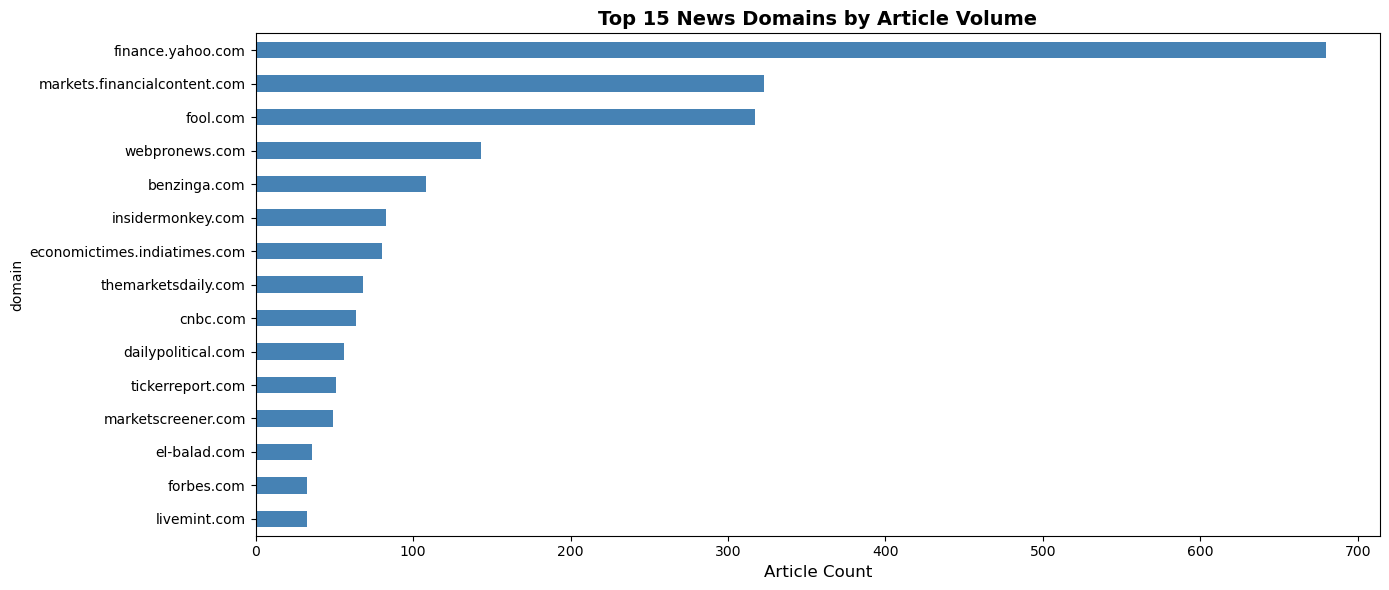

In [53]:
# Visualization: Domain concentration
fig, ax1 = plt.subplots(figsize=(14, 6))

# Top 15 domains bar chart
top_domains.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Article Count', fontsize=12)
ax1.set_title('Top 15 News Domains by Article Volume', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

plt.tight_layout()
plt.show()

## **Sentiment Bias by Domain**

Do certain sources systematically lean positive or negative?

In [54]:
# Calculate sentiment statistics by domain (for domains with 10+ articles)
domain_sentiment = df.groupby('domain').agg({
    'sentiment_score': ['mean', 'std', 'count'],
    'sentiment_present': 'mean'
}).round(3)

domain_sentiment.columns = ['avg_sentiment', 'std_sentiment', 'article_count', 'pct_with_sentiment']
domain_sentiment = domain_sentiment[domain_sentiment['article_count'] >= 10].sort_values('avg_sentiment', ascending=False)


print("Sentiment Bias by Domain (10+ articles only)")
print("=" * 80)
print(f"\nMost POSITIVE domains:")
print(domain_sentiment.head(10).to_string())

print(f"\nMost NEGATIVE domains:")
print(domain_sentiment.tail(10).to_string())

Sentiment Bias by Domain (10+ articles only)

Most POSITIVE domains:
                              avg_sentiment  std_sentiment  article_count  pct_with_sentiment
domain                                                                                       
fool.com                              0.401          0.516            317               0.562
proactiveinvestors.com                0.271          0.641             16               0.688
morningstar.com                       0.249          0.600             27               0.593
markets.financialcontent.com          0.246          0.591            323               0.576
finance.yahoo.com                     0.245          0.527            680               0.471
businessinsider.com                   0.241          0.524             22               0.455
insidermonkey.com                     0.231          0.434             83               0.349
itnewsonline.com                      0.231          0.535             11            

## **3. Volume vs. Sentiment Relationship**

Do high-volume sources show more neutral sentiment (balanced reporting)?
Or do they lean towards sensationalism?

In [55]:
domain_stats = df.groupby('domain').agg({
    'sentiment_score': 'mean',
    'url': 'count'
}).rename(columns={'url': 'article_count', 'sentiment_score': 'avg_sentiment'})

domain_stats = domain_stats[domain_stats['article_count'] >= 5]

# Add absolute sentiment (distance from neutral)
domain_stats['abs_sentiment'] = domain_stats['avg_sentiment'].abs()

# Correlation
correlation = domain_stats[['article_count', 'abs_sentiment']].corr().iloc[0, 1]

print(f"Correlation between volume and sentiment: {correlation:.3f}")
print(f"(Negative = high-volume sources tend to be more neutral)")

Correlation between volume and sentiment: 0.082
(Negative = high-volume sources tend to be more neutral)


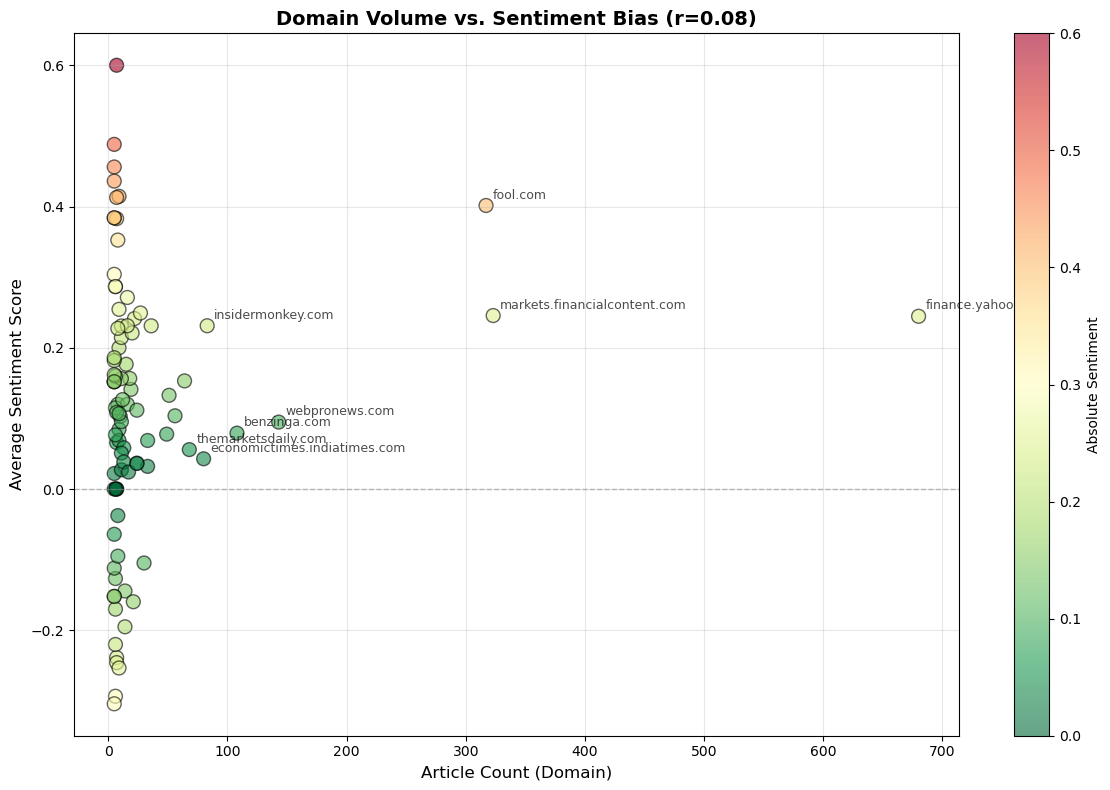

In [58]:
# Scatter plot: volume vs average sentiment
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(domain_stats['article_count'], 
                     domain_stats['avg_sentiment'],
                     s=100, alpha=0.6, c=domain_stats['abs_sentiment'], 
                     cmap='RdYlGn_r', edgecolors='black')

# Annotate top domains
top_annotate = domain_stats.nlargest(8, 'article_count').index
for domain in top_annotate:
    row = domain_stats.loc[domain]
    ax.annotate(domain, 
                xy=(row['article_count'], row['avg_sentiment']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.7)

ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Article Count (Domain)', fontsize=12)
ax.set_ylabel('Average Sentiment Score', fontsize=12)
ax.set_title(f'Domain Volume vs. Sentiment Bias (r={correlation:.2f})', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Sentiment', fontsize=10)

plt.tight_layout()
plt.show()

# **Domain x Ticker Analysis**
What companies are the most 'relevant' tickers talking about

In [60]:
# Identify domains with strong ticker preferences
for domain in top_10_domains:
    domain_df = df[df['domain'] == domain]
    ticker_dist = domain_df['ticker'].value_counts()
    top_ticker = ticker_dist.index[0]
    top_pct = (ticker_dist.iloc[0] / len(domain_df) * 100)
    
    if top_pct > 30:  # Flag if > 30% of articles focus on one ticker
        print(f"{domain:30s} heavily covers {top_ticker} ({top_pct:.1f}% of articles)")

finance.yahoo.com              heavily covers NVDA (47.2% of articles)
fool.com                       heavily covers NVDA (33.4% of articles)


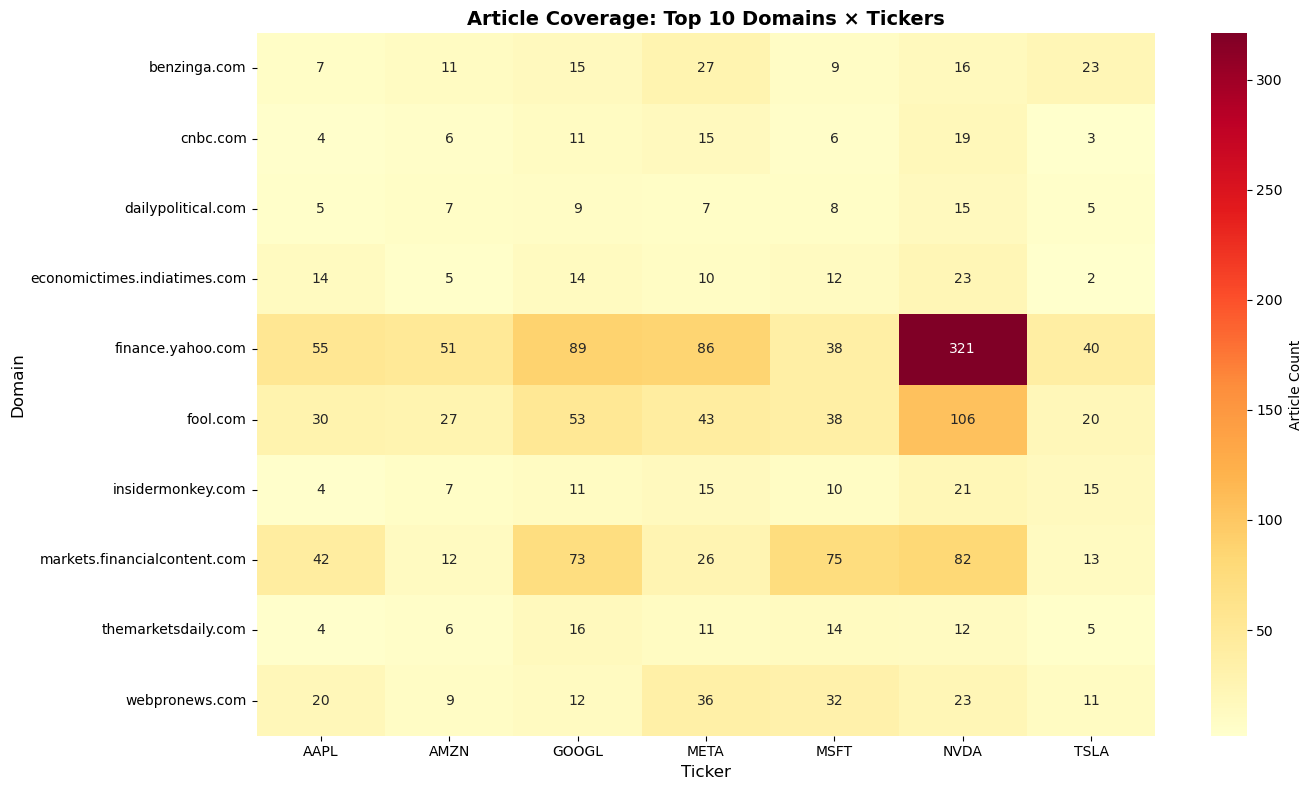

In [59]:
# Domain-ticker heatmap (top 10 domains only)
top_10_domains = domain_counts.head(10).index
df_top10 = df[df['domain'].isin(top_10_domains)]

# Create pivot table
domain_ticker_matrix = df_top10.pivot_table(
    index='domain', 
    columns='ticker', 
    values='url', 
    aggfunc='count',
    fill_value=0
)

# Heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(domain_ticker_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Article Count'}, ax=ax)
ax.set_title('Article Coverage: Top 10 Domains × Tickers', fontsize=14, fontweight='bold')
ax.set_xlabel('Ticker', fontsize=12)
ax.set_ylabel('Domain', fontsize=12)
plt.tight_layout()
plt.show()

In [64]:
# Identify domains with strong ticker preferences
for domain in top_10_domains:
    domain_df = df[df['domain'] == domain]
    ticker_dist = domain_df['ticker'].value_counts()
    top_ticker = ticker_dist.index[0]
    top_pct = (ticker_dist.iloc[0] / len(domain_df) * 100)
    
    if top_pct > 40:  # Flag if > 40% of articles focus on one ticker
        print(f"WARNING: {domain:30s} heavily covers {top_ticker} ({top_pct:.1f}% of articles)")

## **Articles with "extreme" sentiment behavior**

In [ ]:
#  Flags sources with extreme sentiment behavior
# Criteria:
# 1. >60% of articles are non-neutral (opinionated sources)
# 2. Avg sentiment magnitude > 0.5 (strongly biased)
# 3. At least 10 articles (enough sample)

extreme_sources = domain_sentiment[
    (domain_sentiment['pct_with_sentiment'] > 0.60) &
    (domain_sentiment['avg_sentiment'].abs() > 0.5) &
    (domain_sentiment['article_count'] >= 10)
].sort_values('avg_sentiment', ascending=False)

print("\n" + "=" * 70)
print("SOURCES WITH EXTREME SENTIMENT BEHAVIOR")
print("Criteria: >60% non-neutral, |avg_sentiment| > 0.5, 10+ articles")
print("=" * 70)

if len(extreme_sources) > 0:
    print(f"\nFound {len(extreme_sources)} extreme sources:\n")
    print(extreme_sources[['avg_sentiment', 'std_sentiment', 'article_count', 'pct_with_sentiment']].to_string())
else:
    print("No sources meet extreme sentiment criteria.")


SOURCES WITH EXTREME SENTIMENT BEHAVIOR
Criteria: >80% non-neutral, |avg_sentiment| > 0.5, 10+ articles
No sources meet extreme sentiment criteria.


In [ ]:
# -- Additional flag: High variance sources (inconsistent sentiment) --
# High std_sentiment with sufficient volume suggests unreliable/clickbait behavior

volatile_sources = domain_sentiment[
    (domain_sentiment['std_sentiment'] > 0.6) &
    (domain_sentiment['article_count'] >= 10)
].sort_values('std_sentiment', ascending=False).head(10)

print("\n" + "=" * 70)
print("SOURCES WITH HIGH SENTIMENT VOLATILITY")
print("High std_sentiment (>0.6) suggests inconsistent editorial voice")
print("=" * 70)

if len(volatile_sources) > 0:
    print(f"\nTop {len(volatile_sources)} most volatile sources:\n")
    print(volatile_sources[['avg_sentiment', 'std_sentiment', 'article_count', 'pct_with_sentiment']].to_string())
else:
    print("\nNo sources with high sentiment volatility found.")


SOURCES WITH HIGH SENTIMENT VOLATILITY
High std_sentiment (>0.6) suggests inconsistent editorial voice

Top 9 most volatile sources:

                                      avg_sentiment  std_sentiment  article_count  pct_with_sentiment
domain                                                                                               
rttnews.com                                   0.221          0.672             20               0.700
proactiveinvestors.com                        0.271          0.641             16               0.688
thehindubusinessline.com                      0.024          0.635             17               0.647
marketscreener.com                            0.078          0.634             49               0.653
thestar.com.my                                0.231          0.634             16               0.625
fool.co.uk                                    0.103          0.628             10               0.500
theglobeandmail.com                           0.0

## **Which domains dominate on high-volume days**

In [84]:
# -- Identify high-volume days --
# Aggregate total articles per day across all tickers
daily_totals = df.groupby('article_date').size().reset_index(name='total_articles')

# Ensure article_date is datetime after groupby
daily_totals['article_date'] = pd.to_datetime(daily_totals['article_date'])

daily_totals = daily_totals.sort_values('total_articles', ascending=False)

# Define high-volume threshold (e.g., top 25% of days)
high_volume_threshold = daily_totals['total_articles'].quantile(0.75)
high_volume_days = daily_totals[daily_totals['total_articles'] >= high_volume_threshold]['article_date']

print("=" * 70)
print("High-volume days analysis")
print("=" * 70)
print(f"High-volume threshold: {high_volume_threshold:.0f} articles/day")
print(f"Number of high-volume days: {len(high_volume_days)}")
print(f"\nTop 5 busiest days:")
for idx, row in daily_totals.head(5).iterrows():
    print(f"  {row['article_date'].date()}: {row['total_articles']} articles")

High-volume days analysis
High-volume threshold: 286 articles/day
Number of high-volume days: 6

Top 5 busiest days:
  2026-02-05: 406 articles
  2026-02-06: 353 articles
  2026-01-08: 325 articles
  2026-02-09: 313 articles
  2026-01-07: 312 articles


In [85]:
# -- Which domains dominate on high-volume days? --
# Convert high_volume_days to a list of dates for matching
high_volume_dates = high_volume_days.dt.date.tolist()

# Ensure article_date is datetime before using .dt accessor
df['article_date'] = pd.to_datetime(df['article_date'])
df['article_date_only'] = df['article_date'].dt.date

high_vol_articles = df[df['article_date_only'].isin(high_volume_dates)]
high_vol_domain_counts = high_vol_articles['domain'].value_counts().head(10)

print("\n" + "=" * 70)
print("DOMAINS DOMINATING HIGH-VOLUME DAYS")
print("=" * 70)
print(f"Articles on high-volume days: {len(high_vol_articles):,}")
print(f"Top 10 domains on busy news days:\n")
for domain, count in high_vol_domain_counts.items():
    pct = (count / len(high_vol_articles) * 100)
    print(f"{domain:40s} {count:4d} articles ({pct:5.1f}%)")

# Compare to overall top domains
print("\nComparison: Do the same domains dominate both high-volume and overall?")
overall_top5 = set(domain_counts.head(5).index)
highvol_top5 = set(high_vol_domain_counts.head(5).index)
overlap = overall_top5 & highvol_top5
print(f"Overlap between top 5 overall and top 5 on high-volume days: {len(overlap)}/5")
if len(overlap) == 5:
    print("Same sources dominate both — consistent concentration pattern")
else:
    different = highvol_top5 - overall_top5
    if different:
        print(f" Different sources emerge on busy days: {different}")
    else:
        print(f"Overlap: {overlap}")

# Clean up temp column
df = df.drop(columns=['article_date_only'])


DOMAINS DOMINATING HIGH-VOLUME DAYS
Articles on high-volume days: 1,995
Top 10 domains on busy news days:

finance.yahoo.com                         308 articles ( 15.4%)
markets.financialcontent.com              225 articles ( 11.3%)
fool.com                                  139 articles (  7.0%)
webpronews.com                             84 articles (  4.2%)
benzinga.com                               58 articles (  2.9%)
economictimes.indiatimes.com               56 articles (  2.8%)
cnbc.com                                   42 articles (  2.1%)
insidermonkey.com                          41 articles (  2.1%)
marketscreener.com                         34 articles (  1.7%)
dailypolitical.com                         28 articles (  1.4%)

Comparison: Do the same domains dominate both high-volume and overall?
Overlap between top 5 overall and top 5 on high-volume days: 5/5
Same sources dominate both — consistent concentration pattern


## **Initial observations and Findings**

### Coverage Concentration
- **Severe concentration risk**: Top 5 domains account for 41% of all articles, top 10 account for 51%
- **finance.yahoo.com dominates at 18%** of total coverage
- **NVIDIA** is highly covered in these articles when compared to other companies

### High-Volume Day Behavior
- Same top domains dominate both regular and high-volume days
- No evidence of niche sources "spiking" coverage during breaking news